<a href="https://colab.research.google.com/github/gundasai/general/blob/master/14_Unet_Depth_2%2BAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semantic Segmentation using Covolutional Neural Network

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
import keras
keras.backend.clear_session()

In [123]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Reproducibiity

In [124]:
import keras
import numpy as np
import random
import tensorflow as tf

keras.backend.clear_session()
random.seed(42)
np.random.seed(42)
#tf.set_random_seed(42)

### Importing the  Library Functions

In [125]:
from keras.layers import *
import keras
from keras.models import Sequential,Model
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
!pip install medpy
from medpy.metric import dc, precision, recall,jc
#!pip install -U scipy==1.2.0
import os
import cv2
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [126]:
#!pip install -U scipy==1.2.0
#from scipy.misc import imsave

### Loading Data

In [127]:
#import os
#os.getcwd()
import os 
os.chdir('/content/drive/My Drive//datasets/dataset')
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1UdaOejRhEeeMQGXLjtSw0puIg-j1BFAP/dataset


In [128]:
trainx = np.load('Skin_ValidX.npy')
trainy = np.load('Skin_ValidY.npy')

validx = np.load('Skin_ValidX.npy')
validy = np.load('Skin_ValidY.npy')

testx = np.load('Skin_TestX.npy')
testy = np.load('Skin_TestY.npy')

In [129]:
print(len(trainx))
print(len(trainy))
print(trainx.shape)
print(trainy.shape)

print(len(validx))
print(len(validy))
print(validx.shape)
print(validy.shape)

print(len(testx))
print(len(testy))
print(testx.shape)
print(testy.shape)

150
150
(150, 192, 256, 3)
(150, 192, 256)
150
150
(150, 192, 256, 3)
(150, 192, 256)
600
600
(600, 192, 256, 3)
(600, 192, 256)


In [130]:
print(np.max(trainx[0]))
print(np.min(trainx[0]))

print(np.max(trainy[0]))
print(np.min(trainy[0]))

216
0
255
0


In [131]:
trainy = trainy/255
validy = validy/255
testy  = testy/255

In [132]:
print(np.max(trainx[0]))
print(np.min(trainx[0]))

print(np.max(trainy[0]))
print(np.min(trainy[0]))

216
0
1.0
0.0


In [133]:
print(np.max(trainx[0]),np.max(validx[0]),np.max(testx[0]))
print(np.min(trainx[0]),np.min(validx[0]),np.min(testx[0]))


print(np.min(trainy[0]),np.min(validy[0]),np.min(testy[0]))
print(np.max(trainy[0]),np.max(validy[0]),np.max(testy[0]))

216 216 255
0 0 1
0.0 0.0 0.0
1.0 1.0 1.0


### Visualizing Data

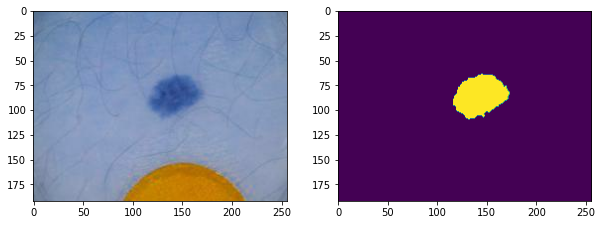

In [134]:
plt.figure(figsize=(10,10))
plt.subplot(121).imshow(trainx [0])
plt.subplot(122).imshow(trainy [0])

### Data Pre-Processing

#### 1. Reshape

In [135]:
trainx = np.reshape(trainx,(-1,192,256,3))
trainy = np.reshape(trainy,(-1,192,256,1))

validx = np.reshape(validx,(-1,192,256,3))
validy = np.reshape(validy,(-1,192,256,1))

testx = np.reshape(testx,(-1,192,256,3))
testy = np.reshape(testy,(-1,192,256,1))

In [136]:
print(trainx.shape)
print(trainy.shape)

print(validx.shape)
print(validy.shape)

print(testx.shape)
print(testy.shape)

(150, 192, 256, 3)
(150, 192, 256, 1)
(150, 192, 256, 3)
(150, 192, 256, 1)
(600, 192, 256, 3)
(600, 192, 256, 1)


#### 2. Normalization

In [137]:
mean = np.mean(trainx)
std  = np.std(trainx)

print(mean)
print(std)

trainx = trainx-mean
trainx = trainx/std

testx = testx-mean
testx = testx/std

validx = validx-mean
validx = validx/std

149.91443788881656
42.02971034402147


### Model

In [138]:
def unet_depth2(input_height=192, input_width=256):

    img_input = Input(shape=(input_height,input_width,3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2, 2))(conv3)
    
    skip1  = concatenate([up1,conv2])
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(skip1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    up2 = UpSampling2D((2, 2))(conv4)
    
    skip2  = concatenate([up2,conv1])
    
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(skip2)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    
    drop1 = Dropout(0.5)(conv5)
   
    o = Conv2D( 1, (1, 1),activation = 'sigmoid' ,padding='same')(drop1)
    
    model = Model(inputs=[img_input], outputs=[ o ])
    
    return model

model=unet_depth2()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 128, 32)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Model Visualization

In [139]:
from keras_preprocessing.image import ImageDataGenerator
data_gen_args = ImageDataGenerator(featurewise_center=False,
                                 featurewise_std_normalization=False, 
                                 samplewise_center=False,
                                 samplewise_std_normalization=False,
                                 horizontal_flip=True,
                                 zoom_range=[0.8,0.9],
                                 rotation_range=30) 

In [140]:
image_datagen = ImageDataGenerator(data_gen_args)
mask_datagen = ImageDataGenerator(data_gen_args)

seed = 2018
bs = 32

In [141]:
image_generator = image_datagen.flow(trainx, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(trainy, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

### Fine-tuning Tricks (callbacks)

In [142]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
os.chdir('/content/drive/My Drive/results')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('unet_up2_Aug.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
cv = keras.callbacks.CSVLogger('unet_up2_Aug.csv', separator=',', append=False)

### Metrics

In [143]:
from keras import backend as K
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Optimizer

In [144]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

### Compile and Train the Model

In [145]:
from keras import backend as K
model.compile(loss=dice_coef_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [160]:
history = model.fit_generator(train_generator, steps_per_epoch=(len(trainx) // 64),callbacks=[es,mc,cv], epochs=200,
                              validation_data=(validx, validy))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: -0.6704 - dice_coef: 0.6704 - accuracy: 0.8936
Epoch 00001: val_loss did not improve from -0.69463
2/2 [==============================] - 2s 852ms/step - loss: -0.6704 - dice_coef: 0.6704 - accuracy: 0.8936 - val_loss: -0.6894 - val_dice_coef: 0.6770 - val_accuracy: 0.9107
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: -0.7535 - dice_coef: 0.7471 - accuracy: 0.9141
Epoch 00002: val_loss did not improve from -0.69463
2/2 [==============================] - 1s 709ms/step - loss: -0.7535 - dice_coef: 0.7471 - accuracy: 0.9141 - val_loss: -0.6931 - val_dice_coef: 0.6813 - val_accuracy: 0.9061
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: -0.6699 - dice_coef: 0.6699 - accuracy: 0.9064
Epoch 00003: val_loss did not improve from -0.69463
2/2 [==============================] - 2s 804ms/step - loss: -0.6699 - dice_coef: 0.6699 - accuracy: 0.9064 - val_loss: -0.6874 - val_dice_coef: 0.6761 

### Evaluating the Model Performance

In [161]:
model.evaluate(testx,testy)

19/19 [==============================] - 4s 189ms/step - loss: -0.6517 - dice_coef: 0.6478 - accuracy: 0.8675


[-0.6517102122306824, 0.6477707028388977, 0.8674972653388977]

In [162]:
model.save("unet_up2_aug_temp.h5")

### Load_Model

In [163]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/results')

In [164]:
from keras.models import load_model
model2 = load_model("unet_up2_Aug.h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
model2.evaluate(testx,testy)

19/19 [==============================] - 4s 194ms/step - loss: -0.6520 - dice_coef: 0.6480 - accuracy: 0.8699


[-0.6520002484321594, 0.6479546427726746, 0.8698926568031311]

In [165]:
preds = model2.predict(testx, verbose = 1)
preds.shape
preds = np.around(preds)

 2/19 [==>...........................] - ETA: 1sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_predict_batch_end` time: 0.1809s). Check your callbacks.


19/19 [==============================] - 4s 193ms/step


In [166]:
def dice(true, preds):  
    scores  = []
    for i in range(len(true)):
        im1 = true[i]
        im2 = preds[i]
        intersection = np.logical_and(im1, im2)
        score = 2. * intersection.sum() / (im1.sum() + im2.sum())
        scores.append(score)
    return np.array(scores).mean(), scores

In [167]:
avg_d_score, d_scores = dice(testy, np.around(preds))
print(avg_d_score)

0.6576032915086627


In [168]:
np.mean(d_scores)

0.6576032915086627

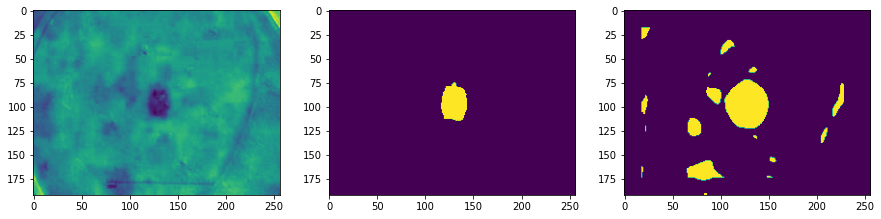

In [178]:
idxx=45 #1
plt.figure(figsize=(15,15))
plt.subplot(131).imshow(testx[idxx][:,:,0])
plt.subplot(132).imshow(testy[idxx][:,:,0])
plt.subplot(133).imshow(preds[idxx][:,:,0])

### Plot Loss and Accuracy

In [170]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

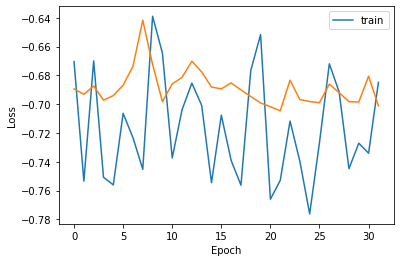

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train'])

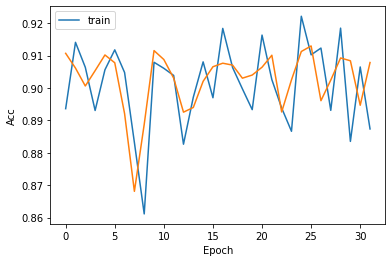

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train'])

### Dice Coefficient

In [173]:
test_pred = model.predict(testx, batch_size=32)
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, testy)
pre  = precision(test_result,testy)
re   = recall(test_result,testy)
print('Test dc: '  + str(dice))
print('Test pre: ' + str(pre))
print('Test re: '  + str(re))

Test dc: 0.7174774839127942
Test pre: 0.7222146615033831
Test re: 0.7128020459047141
